### Install Neural A* on Colab

We highly recommend the use of GPUs for faster training/planning.

In [ ]:
!nvidia-smi

In [ ]:
!git clone --recursive https://github.com/vd-kuznetsov/neural-astar

In [ ]:
%cd neural-astar
!pip install -U pip setuptools
!pip install -e .

Выполнить ячейку после перезапуска runtime

In [ ]:
%cd neural-astar

## Shortest path search with Neural A* 

Neural A\*, as well as vanilla differentiable A\* can be instantiated just like a neural network module.

In [ ]:
import torch
from neural_astar.planner import NeuralAstar, VanillaAstar
from neural_astar.utils.training import load_from_ptl_checkpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

neural_astar = NeuralAstar(encoder_arch='CNN').to(device)
neural_astar.load_state_dict(load_from_ptl_checkpoint("model/mazes_032_moore_c8/lightning_logs/"))

vanilla_astar = VanillaAstar().to(device)

Running these A\* modules requires `map_designs` (obstacle layouts), `start_maps`, and `goal_maps` (one-hot maps indicating start and goal locations), which should each have the shape of `(batch_size, 1, map_size, map_size)`.

Number of Test Samples: 100
	Size: 32x32


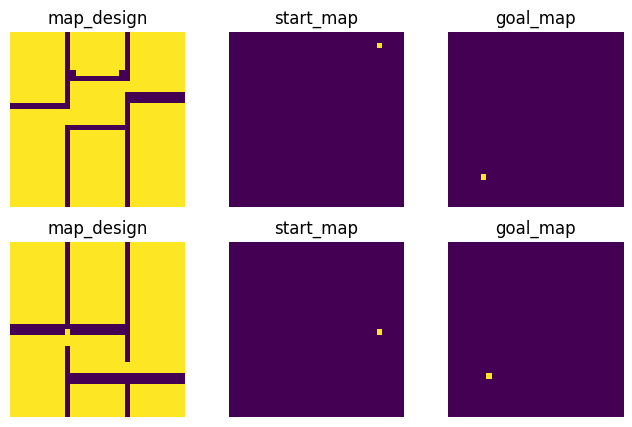

In [3]:
import matplotlib.pyplot as plt
from neural_astar.utils.data import create_dataloader

dataloader = create_dataloader("planning-datasets/data/mpd/mazes_032_moore_c8.npz", "test", 8)
map_designs, start_maps, goal_maps, _ = next(iter(dataloader))

fig, axes = plt.subplots(2, 3, figsize=[8, 5])
for i in range(2):
    axes[i, 0].imshow(map_designs.numpy()[i, 0])
    axes[i, 0].set_title("map_design")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(start_maps.numpy()[i, 0])
    axes[i, 1].set_title("start_map")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(goal_maps.numpy()[i, 0])
    axes[i, 2].set_title("goal_map")
    axes[i, 2].axis("off")

Then, search can be performed by simply forwarding the model. The output is namedtuple `AstarOutput` with `histories` (search history maps) and `paths` (path maps).

/usr/local/lib/python3.10/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(-0.5, 273.5, 35.5, -0.5)

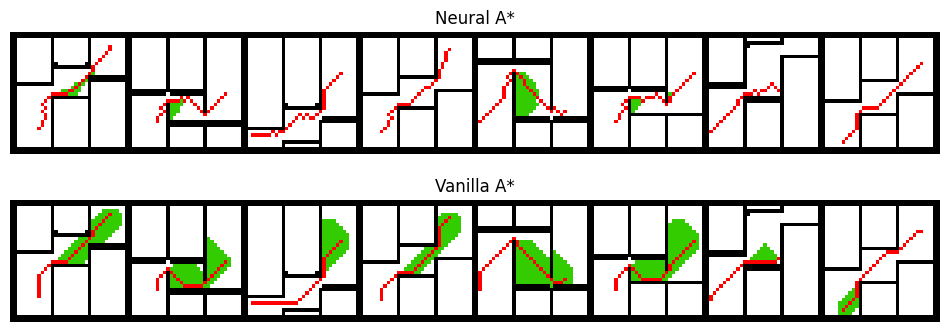

In [4]:
from neural_astar.utils.data import visualize_results

neural_astar.eval()
na_outputs = neural_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))
vanilla_astar.eval()
va_outputs = vanilla_astar(map_designs.to(device), start_maps.to(device), goal_maps.to(device))

fig, axes = plt.subplots(2, 1, figsize=[12, 4])
axes[0].imshow(visualize_results(map_designs, na_outputs))
axes[0].set_title("Neural A*")
axes[0].axis("off")
axes[1].imshow(visualize_results(map_designs, va_outputs))
axes[1].set_title("Vanilla A*")
axes[1].axis("off")

# Warcraft

In [ ]:
!pip install wandb

Download Data

In [6]:
!gdown 1_q4qScXJg19BpXiOpKLgKamw0JuH2BN7
!tar -xf warcraft_maps.tar.gz
!mv warcraft_shortest_path_oneskin warcraft

Downloading...
From: https://drive.google.com/uc?id=1_q4qScXJg19BpXiOpKLgKamw0JuH2BN7
To: /content/neural-astar/warcraft_maps.tar.gz
100% 915M/915M [00:23<00:00, 39.1MB/s]


Train Neural A*

In [ ]:
!python scripts/train_warcraft.py

Neural A* can also be trained to perform plannig on a raw image input. Here we present some examples with WarCraft dataset available at Blackbox Combinatorial Solvers page.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from neural_astar.planner import NeuralAstar
from neural_astar.utils.data import create_warcraft_dataloader
from neural_astar.utils.training import load_from_ptl_checkpoint

Just like the cases with shortest-path search problems, we prepare a dataset consisting of map_designs, start_maps, goal_maps, and opt_trajs. But this time map_designs are colored images instead of binary obstacle maps.

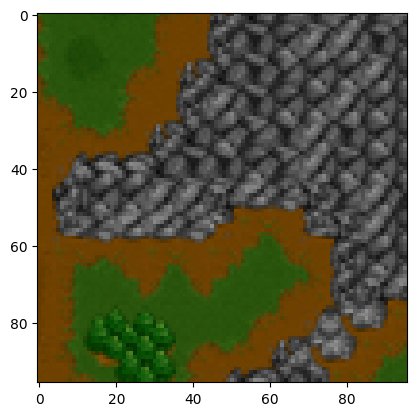

In [ ]:
dataloader = create_warcraft_dataloader("warcraft/12x12/", "test", 10)
map_designs, start_maps, goal_maps, opt_trajs = next(iter(dataloader))

plt.imshow(map_designs[0].permute(1, 2, 0))

For training with such real images, Neural A* is configured to have (1) rgb+ inputs consisting of RGB images and binary start+goal maps and (2) learn_obstacles=True indicating that the visual representation of obstacles is learned during training. Other args encoder_arch, encoder_depth, and const are also set properly for handling warcraft data.

In [ ]:
import re
from glob import glob

model = NeuralAstar(encoder_input="rgb+", encoder_arch="CNNDownSize", encoder_depth=3, learn_obstacles=True, Tmax=1.0, const=10.)
#model.load_state_dict(load_from_ptl_checkpoint("model/12x12/lightning_logs"))

state_dict = torch.load("Neural_A_star/goqhwrtl/checkpoints/epoch=76-step=7700.ckpt")["state_dict"]
state_dict_extracted = dict()
for key in state_dict:
    if "planner" in key:
        state_dict_extracted[re.split("planner.", key)[-1]] = state_dict[key]

model.load_state_dict(state_dict_extracted)

<All keys matched successfully>

Then, Neural A* can be used in the same manner as for shortest path search.

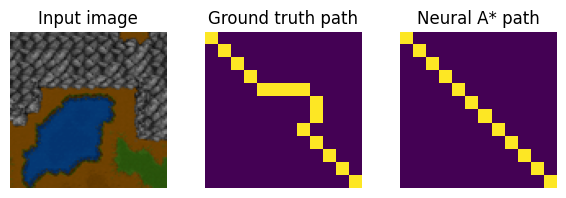

In [ ]:
outputs = model(map_designs, start_maps, goal_maps)

t = 9
fig, axes = plt.subplots(1, 3, figsize=[6, 2])
axes[0].imshow(map_designs[t].permute(1, 2, 0))
axes[0].axis("off")
axes[1].imshow(opt_trajs[t, 0])
axes[0].set_title("Input image")
axes[1].axis("off")
axes[1].set_title("Ground truth path")
axes[2].imshow(outputs.paths[t, 0])
axes[2].axis("off")
axes[2].set_title("Neural A* path")
fig.tight_layout()
plt.savefig("assets/warcraft.png")